In [1]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
# Upload your Kaggle API key for dataset extraction
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdabraralzabir","key":"b6e9da16433a52f8a2353d7d5c743971"}'}

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d obulisainaren/retinal-oct-c8/

Dataset URL: https://www.kaggle.com/datasets/obulisainaren/retinal-oct-c8/versions/
License(s): CC-BY-NC-SA-4.0
100% 1.41G/1.42G [00:15<00:00, 32.7MB/s]
100% 1.42G/1.42G [00:16<00:00, 94.9MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/retinal-oct-c8.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [5]:
# Load the dataset using image_dataset_from_directory
train_dir = "/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/train"
val_dir = "/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/val"
test_dir = "/content/dataset/RetinalOCT_Dataset/RetinalOCT_Dataset/test"

In [6]:
# Get class names
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


In [7]:
#1 Load Dataset and Preprocessing
IMG_SIZE = (299, 299)  # InceptionV3 input size
BATCH_SIZE = 32

In [8]:
# Apply preprocessing function to dataset
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # InceptionV3-specific preprocessing
    return image, label

In [9]:
# Load the datasets and apply preprocessing
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
val_dataset = image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 18400 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.


In [10]:
# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [11]:
# Prefetch for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
#2 Data Augmentation & Visualization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

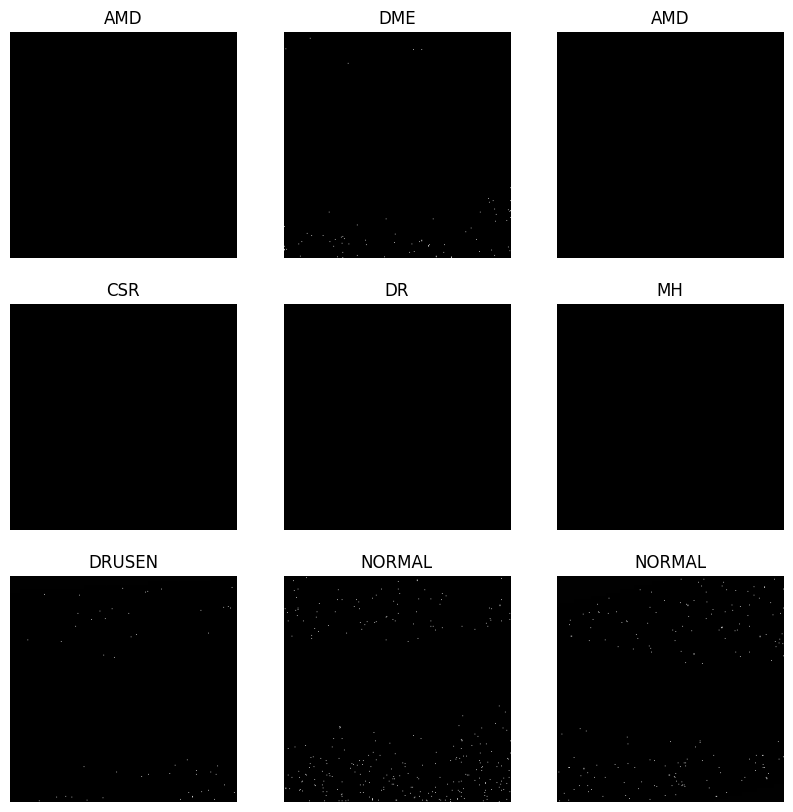

In [13]:
# Display first 9 images & labels
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [14]:
#3 Build Model (InceptionV3)
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Freeze base model
base_model.trainable = False

# Build model
model = tf.keras.Sequential([
    data_augmentation,  # Data augmentation applied here
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Multi-class classification
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [16]:
# Train Model with Checkpoints
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy")

In [17]:
# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[checkpoint_cb])

Epoch 1/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 129s 201ms/step - accuracy: 0.5153 - loss: 1.3273 - val_accuracy: 0.7579 - val_loss: 0.6495
Epoch 2/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 107s 186ms/step - accuracy: 0.7145 - loss: 0.7152 - val_accuracy: 0.7893 - val_loss: 0.5481
Epoch 3/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 107s 185ms/step - accuracy: 0.7325 - loss: 0.6693 - val_accuracy: 0.7843 - val_loss: 0.5377
Epoch 4/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - accuracy: 0.7537 - loss: 0.6201 - val_accuracy: 0.7979 - val_loss: 0.5076
Epoch 5/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 107s 186ms/step - accuracy: 0.7499 - loss: 0.6348 - val_accuracy: 0.7907 - val_loss: 0.5186
Epoch 6/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 148s 197ms/step - accuracy: 0.7596 - loss: 0.6127 - val_accuracy: 0.7904 - val_loss: 0.5397
Epoch 7/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 134s 184ms/step - accuracy: 0.7633 - loss: 0.5902 - val_accuracy: 0.7932 - val_loss: 0.5295
Epoch 8/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 143s 186ms/step - accuracy: 0.7763 -

In [18]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc*100:.2f}%")

88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.8721 - loss: 0.3419
Test accuracy: 84.43%


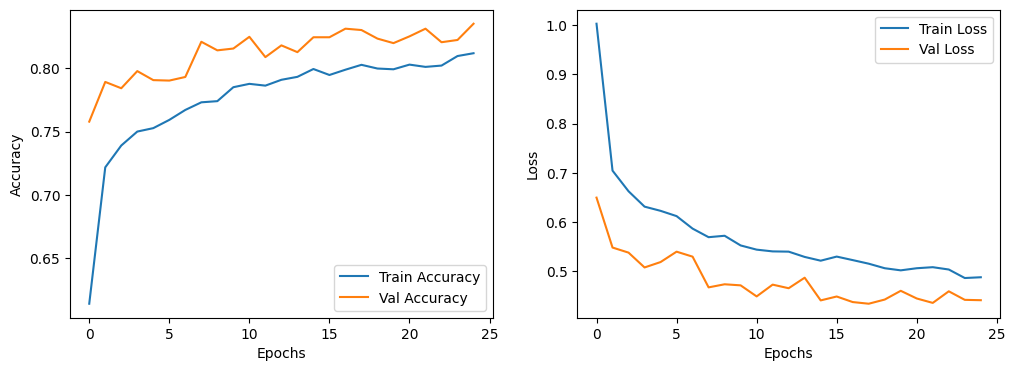

In [19]:
# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
#4 Fine-Tune Model (Unfreeze Layers)
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# Fine-tune model
fine_tune_history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[checkpoint_cb])

Epoch 1/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 423s 654ms/step - accuracy: 0.6073 - loss: 1.1762 - val_accuracy: 0.8325 - val_loss: 0.4284
Epoch 2/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 384s 668ms/step - accuracy: 0.8480 - loss: 0.4100 - val_accuracy: 0.8839 - val_loss: 0.3125
Epoch 3/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 441s 665ms/step - accuracy: 0.8967 - loss: 0.2938 - val_accuracy: 0.9175 - val_loss: 0.2329
Epoch 4/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 441s 663ms/step - accuracy: 0.9173 - loss: 0.2294 - val_accuracy: 0.9293 - val_loss: 0.2055
Epoch 5/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 380s 661ms/step - accuracy: 0.9292 - loss: 0.2059 - val_accuracy: 0.9368 - val_loss: 0.1858
Epoch 6/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 385s 670ms/step - accuracy: 0.9392 - loss: 0.1778 - val_accuracy: 0.9332 - val_loss: 0.2142
Epoch 7/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 384s 668ms/step - accuracy: 0.9466 - loss: 0.1578 - val_accuracy: 0.9418 - val_loss: 0.1782
Epoch 8/15
575/575 ━━━━━━━━━━━━━━━━━━━━ 438s 662ms/step - accuracy: 0.9512 -

In [22]:
# Evaluate the model again after fine tuning, on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc*100:.2f}%")

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9657 - loss: 0.1165
Test accuracy: 96.43%


In [23]:
history = fine_tune_history

In [25]:
#5 Evaluate Model (Accuracy, Predictions, Confidence)
y_true, y_pred, y_conf = [], [], []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_conf.extend(np.max(preds, axis=1))  # Confidence score

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [26]:
# Print sample predictions
for i in range(10):
    print(f"Actual: {class_names[y_true[i]]}, Predicted: {class_names[y_pred[i]]}, Confidence: {y_conf[i]:.2f}")

Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00
Actual: AMD, Predicted: AMD, Confidence: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


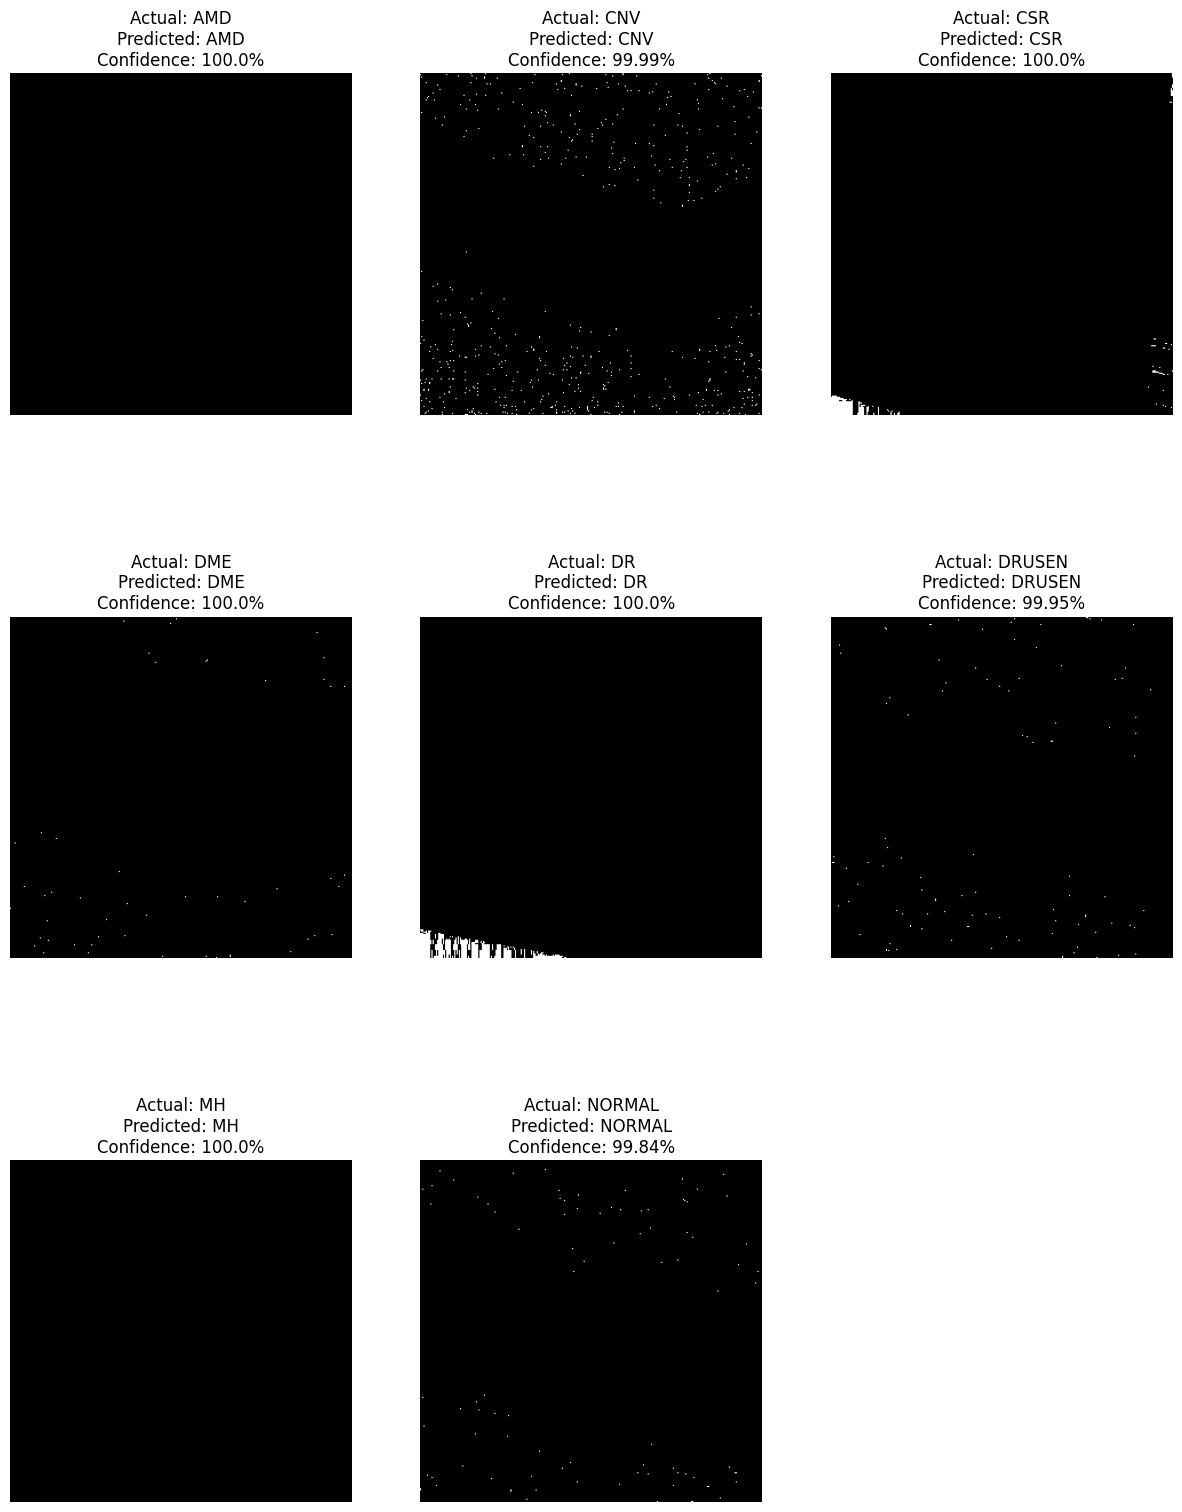

In [40]:
# Manually select specific images from test set (adjust indices as needed)
specific_indices = [0, 351, 701, 1051, 1401, 1751, 2120, 2455]  # Change based on dataset size

plt.figure(figsize=(15, 20))
for i, idx in enumerate(specific_indices):
    image, label = test_dataset.unbatch().skip(idx).take(1).as_numpy_iterator().next()

    # Preprocess image for model
    img_array = tf.expand_dims(image, 0)  # Convert to batch format
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    actual_class = class_names[label]

    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")

plt.show()


In [41]:
# Compute Precision, Recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9649
Recall: 0.9643
F1-score: 0.9644


In [42]:
# Save model in TensorFlow's recommended `.keras` format
model.save("/content/inceptionv3.keras")

In [45]:
model.export("/content/inceptionv3e")

Saved artifact at '/content/inceptionv3e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136985758861264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758862800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758863568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758873744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758874320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758873936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758875088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985758875280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985701303312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136985701303504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13698